# Models (sepsis-pics)


## Common


In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
def plot_roc(input_path):

    df_roc = pd.read_csv(input_path, sep='\t')
    ax = plt.subplot()

    ax.set_title('CatBoost ROC')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')

    t = [0, 1]
    ax.plot(t, t, '--', c='lightgray')

    x = df_roc['FPR']
    y = df_roc['TPR']
    ax.plot(x, y, 'b-')


## Prepare Data


In [3]:
df_data = pd.read_csv(
    './data_eicu_compact_pics.csv',
    index_col='patientunitstayid',
)

y_labels = ['pics']
X = df_data.drop(columns=y_labels)
y = df_data[y_labels]


In [4]:
df_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4524 entries, 141297 to 3353251
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          4524 non-null   float64
 1   urine        4524 non-null   float64
 2   wbc          4524 non-null   float64
 3   meanbp       4524 non-null   float64
 4   vasopressor  4524 non-null   int64  
 5   hr           4524 non-null   float64
 6   creatinine   4524 non-null   float64
 7   platelet     4524 non-null   float64
 8   inr          4524 non-null   float64
 9   pt           4524 non-null   float64
 10  ptt          4524 non-null   float64
 11  lactate      4524 non-null   float64
 12  rdw          4524 non-null   float64
 13  bilirubin    4524 non-null   float64
 14  bicarbonate  4524 non-null   float64
 15  pics         4524 non-null   bool   
dtypes: bool(1), float64(14), int64(1)
memory usage: 569.9 KB


In [5]:
X.head(5)


,age,urine,wbc,meanbp,vasopressor,hr,creatinine,platelet,inr,pt,ptt,lactate,rdw,bilirubin,bicarbonate
patientunitstayid,,,,,,,,,,,,,,,
141297,63.0,-1.0,17.3,177.0,0,135.0,5.413333,440.000000,2.15000,23.650000,28.0,9.25,20.066667,0.7,23.000000
141432,75.0,-1.0,9.8,48.0,0,76.0,0.965000,227.000000,2.00000,22.200000,31.0,2.00,13.100000,0.7,31.000000
143578,65.0,-1.0,16.0,48.0,0,64.0,4.326129,165.290323,1.82069,19.327586,53.6,1.50,17.135484,0.4,28.307692
143897,57.0,-1.0,-1.0,131.0,0,86.0,4.448333,136.714286,0.90000,9.900000,25.0,1.60,17.257143,0.4,25.166667
144034,38.0,-1.0,22.9,68.0,0,98.0,0.803846,390.909091,0.90000,9.400000,30.0,2.20,13.709091,0.5,28.416667


In [6]:
y.head(5)


,pics
patientunitstayid,
141297,False
141432,False
143578,False
143897,False
144034,False


## CatBoost


In [7]:
from catboost import CatBoostClassifier, cv as catboost_cv, \
    Pool as CatboostPool
from catboost.utils import get_roc_curve as catboost_roc


In [8]:
catboost_pool = CatboostPool(X, y)


In [9]:
catboost_model = CatBoostClassifier(
    # task_type='GPU',
    # devices='0',  # GPU ID
    verbose=False,
)

catboost_model.fit(
    X,
    y,
    plot=True,
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [9]:
catboost_scores = catboost_cv(
    catboost_pool,
    fold_count=3,
    logging_level='Silent',
    params={
        'loss_function': 'Logloss',
        'verbose': False,
        'roc_file': 'roc_catboost.tsv',
        'custom_metric': 'AUC',
    },
)


In [10]:
catboost_scores.describe().iloc[-1, :]


iterations            999.000000
test-Logloss-mean       0.626249
test-Logloss-std        0.001920
train-Logloss-mean      0.625900
train-Logloss-std       0.003127
test-AUC-mean           0.681432
test-AUC-std            0.080935
Name: max, dtype: float64

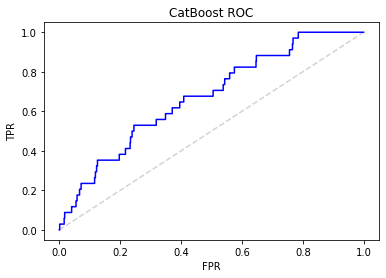

In [11]:
plot_roc('./catboost_info/roc_catboost.tsv')
